In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from prophet import Prophet

In [5]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [6]:
#df

In [7]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Februar-25", "Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [8]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [17]:
# Loop through each column in the DataFrame and apply Prophet separately
future_predictions = {}

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    df_prophet = df[[party]].reset_index()
    df_prophet.columns = ["ds", "y"]  # Prophet requires 'ds' (date) and 'y' (value)
    
    model = Prophet()
    model.fit(df_prophet)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=8, freq='ME')  # 8 month-end predictions
    forecast = model.predict(future)
    
    future_predictions[party] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

22:06:53 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:55 - cmdstanpy - INFO - Chain [1] done processing
22:06:55 - cmdstanpy - INFO - Chain [1] start processing
22:06:55 - cmdstanpy - INFO - Chain [1] done processing
22:06:55 - cmdstanpy - INFO - Chain [1] start processing
22:06:56 - cmdstanpy - INFO - Chain [1] done processing
22:06:56 - cmdstanpy - INFO - Chain [1] start processing
22:06:56 - cmdstanpy - INFO - Chain [1] done processing
22:06:56 - cmdstanpy - INFO - Chain [1] start processing
22:06:56 - cmdstanpy - INFO - Chain [1] done processing
22:06:57 - cmdstanpy - INFO - Chain [1] start processing
22:06:57 - cmdstanpy - INFO - Chain [1] done processing
22:06:57 - cmdstanpy - INFO - Chain [1] start processing
22:06:57 - cmdstanpy - INFO - Chain [1]

In [18]:
future_predictions

{'Ap':            ds       yhat  yhat_lower  yhat_upper
 0  2021-01-31  25.951865   24.783450   27.134101
 1  2021-02-28  25.476336   24.292431   26.755054
 2  2021-03-31  24.716843   23.588323   25.863586
 3  2021-04-30  25.080721   23.948027   26.191380
 4  2021-05-31  25.023360   23.838860   26.185452
 5  2021-06-30  24.655317   23.516600   25.716172
 6  2021-07-31  25.054725   24.015777   26.261185
 7  2021-08-31  24.381551   23.160280   25.482052
 8  2021-09-30  24.335463   23.170673   25.504999
 9  2021-10-31  24.601902   23.506114   25.791709
 10 2021-11-30  23.470351   22.273998   24.674895
 11 2021-12-31  21.741257   20.519412   22.960308
 12 2022-01-31  22.533617   21.327869   23.699825
 13 2022-02-28  21.849928   20.720137   22.965372
 14 2022-03-31  21.199004   20.005062   22.314547
 15 2022-04-30  21.790419   20.608026   22.984913
 16 2022-05-31  21.746549   20.553528   22.920765
 17 2022-06-30  21.324104   20.159720   22.408748
 18 2022-07-31  21.671922   20.474827   22.8

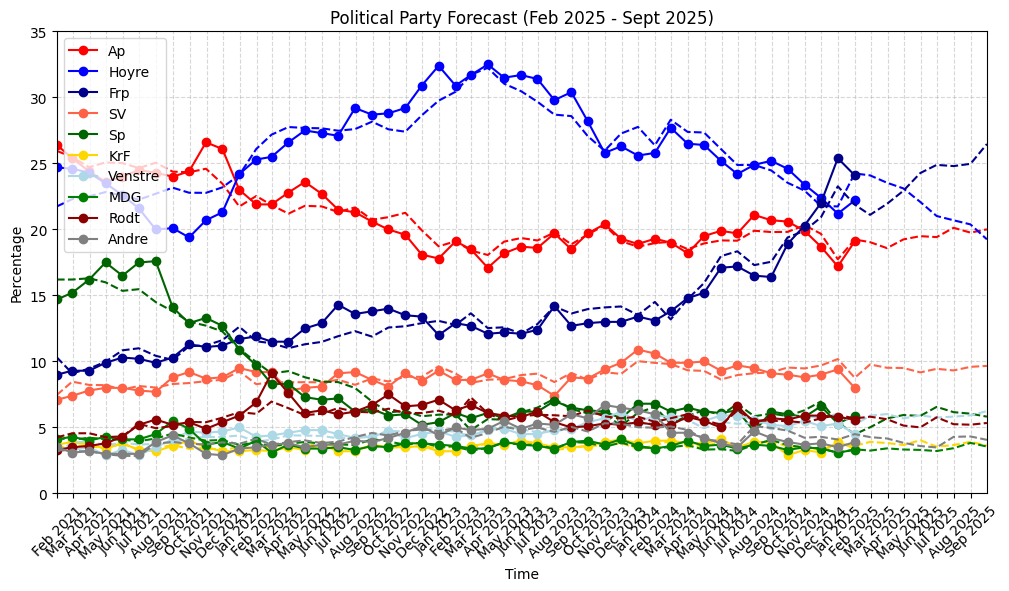

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")
    
    # Check if forecast exists for this party
    if party in future_predictions:
        forecast_df = future_predictions[party]  # Get forecast dataframe for this party
        
        # Plot Prophet's forecast (dashed line)
        plt.plot(forecast_df['ds'], forecast_df['yhat'], linestyle="dashed", color=color)

# Set x-axis limits: Min from original data, max to Sept 2025
plt.xlim(df.index.min(), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025

# Set x-axis ticks for only months where we have data
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Auto-detect month positions
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as "Jan 2025"

# Format y-axis for every whole percentage
plt.yticks(np.arange(0, 40, 5))  # Assuming percentages from 0 to 100

# Add grid lines
plt.grid(True, linestyle="--", alpha=0.5)  # Light dashed grid

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")

# Move legend to the upper left
plt.legend(loc="upper left")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()
